In [26]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

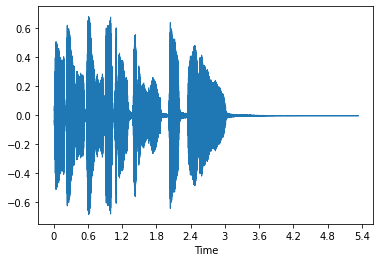

In [6]:
# Play at double speed

y, sr   = librosa.load(librosa.ex('trumpet'))
librosa.display.waveshow(y)


In [9]:
ipd.Audio(y, rate=sr)

### Plot frequency harmonics for spectrograms

In [16]:
harmonics = [1./3, 1./2, 1, 2, 3, 4]
S = np.abs(librosa.stft(y))
fft_freqs = librosa.fft_frequencies(sr=sr)
S_harm = librosa.interp_harmonics(S, freqs=fft_freqs, harmonics=harmonics, axis=0)
print(S_harm.shape)

(6, 1025, 230)


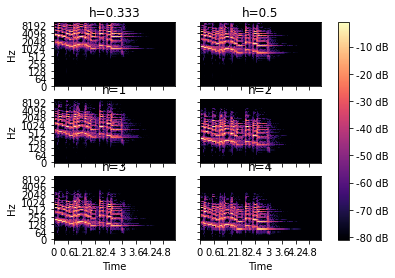

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)

for i, _sh in enumerate(S_harm):
    img = librosa.display.specshow(librosa.amplitude_to_db(_sh, ref=S.max()), sr=sr, y_axis='log', x_axis='time',ax=ax.flat[i])
    ax.flat[i].set(title='h={:.3g}'.format(harmonics[i]))
    ax.flat[i].label_outer()
    
fig.colorbar(img, ax=ax, format="%+2.f dB")

### Phase vocoder with librosa

In [10]:
D       = librosa.stft(y, n_fft=2048, hop_length=512)
D_fast  = librosa.phase_vocoder(D, rate=2.0, hop_length=512)
y_fast  = librosa.istft(D_fast, hop_length=512)

In [11]:
ipd.Audio(y_fast, rate=sr)

In [12]:
D_slow  = librosa.phase_vocoder(D, rate=1./3, hop_length=512)
y_slow  = librosa.istft(D_slow, hop_length=512)

In [13]:
ipd.Audio(y_slow, rate=sr)

### Compute ADSR

In [23]:
def compute_adsr(len_A=10, len_D=10, len_S=60, len_R=10, height_A=1.0, height_S=0.5):
    """Computation of idealized ADSR model
    """
    curve_A = np.arange(len_A) * height_A / len_A
    curve_D = height_A - np.arange(len_D) * (height_A - height_S) / len_D
    curve_S = np.ones(len_S) * height_S
    curve_R = height_S * (1 - np.arange(1, len_R + 1) / len_R)
    curve_ADSR = np.concatenate((curve_A, curve_D, curve_S, curve_R))
    return curve_ADSR

In [24]:
curve_ADSR = compute_adsr(len_A=10, len_D=10, len_S=60, len_R=10, height_A=1.0, height_S=0.5)

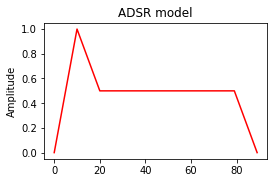

In [31]:
plt.figure(figsize=(4,2.5))
plt.plot(curve_ADSR, color='red')
plt.title('ADSR model')
plt.ylabel('Amplitude')
plt.show()

#### Envolope computation

In [32]:
def compute_envelope(x, win_len_sec=0.01, Fs=4000):
    win_len_half = round(win_len_sec * Fs * 0.5)
    N = x.shape[0]
    env = np.zeros(N)
    env_upper = np.zeros(N)
    env_lower = np.zeros(N)
    for i in range(N):
        i_start = max(0, i - win_len_half)
        i_end = min(N, i + win_len_half)
        env[i] = np.amax(np.abs(x)[i_start:i_end])
        env_upper[i] = np.amax(x[i_start:i_end])
        env_lower[i] = np.amin(x[i_start:i_end])
    return env, env_upper, env_lower

def compute_plot_envelope(x, win_len_sec, Fs, figsize=(6, 3), title=''):
    t = np.arange(x.size)/Fs
    env, env_upper, env_lower = compute_envelope(x, win_len_sec=win_len_sec, Fs=Fs)
    fig = plt.figure(figsize=figsize)
    plt.plot(t, x, color='gray', label='Waveform')
    plt.plot(t, env_upper, linewidth=2, color='cyan', label='Upper envelope')
    plt.plot(t, env_lower, linewidth=2, color='blue', label='Lower envelope')
    plt.plot(t, env, linewidth=2, color='red', label='Magnitude envelope')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t[0], t[-1]])
    plt.ylim([-0.7, 0.7])
    plt.legend(loc='lower right')
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))
    return fig

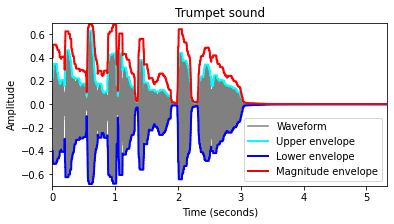

In [34]:
fig = compute_plot_envelope(y, win_len_sec=0.05, Fs=sr, title='Trumpet sound')



### Generate sinusoid signal with tremolo and vibrato

In [35]:
def generate_sinusoid_tremolo(dur=5, Fs=1000, amp=0.5, freq=440, trem_amp=0.1, trem_rate=5):

    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    amps = amp + trem_amp * np.sin(t * 2 * np.pi * trem_rate)
    x = amps * np.sin(2*np.pi*(freq*t))
    return x, t

amplitude modulations are also known as tremolo

In [36]:
Fs = 4000
dur = 5
freq = 220
amp = 0.5
figsize = (8,2)
x_trem, t = generate_sinusoid_tremolo(dur=dur, Fs=Fs, amp=amp, freq=freq, trem_amp=0.3, trem_rate=5)

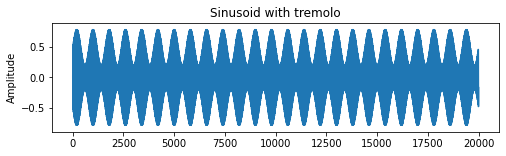

In [37]:
plt.figure(figsize=figsize)
plt.plot(x_trem)
plt.title('Sinusoid with tremolo')
plt.ylabel('Amplitude')
plt.ylim([-0.9, 0.9])
plt.show()
ipd.display(ipd.Audio(data=x_trem, rate=Fs))

In [40]:
def generate_sinusoid_vibrato(dur=5, Fs=1000, amp=0.5, freq=440, vib_amp=1, vib_rate=5):
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    freq_vib = freq + vib_amp * np.sin(t * 2 * np.pi * vib_rate)
    phase_vib = np.zeros(num_samples)
    for i in range(1, num_samples):
        phase_vib[i] = phase_vib[i-1] + 2 * np.pi * freq_vib[i-1] / Fs
    x = amp * np.sin(phase_vib)
    return x, t

musical effect consisting of a regular, pulsating change of frequency (frequency modulations)

In [41]:
x_vib, t = generate_sinusoid_vibrato(dur=dur, Fs=Fs, amp=amp, freq=freq, vib_amp=6, vib_rate=5)

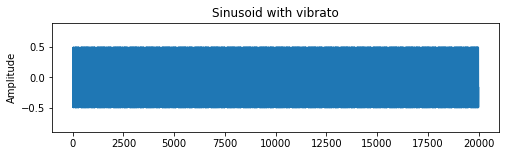

In [42]:
plt.figure(figsize=figsize)
plt.plot(x_vib)
plt.title('Sinusoid with vibrato')
plt.ylabel('Amplitude')
plt.ylim([-0.9, 0.9])
plt.show()
ipd.display(ipd.Audio(data=x_vib, rate=Fs))